In [51]:
import numpy as np
import matplotlib.pyplot as plt

import pywt.data
import sys
import cv2

if '..' not in sys.path:
    sys.path.append('..')

from stego.transform import blocking, dwt
from stego import encoder

In proposed MDLE-IWT method, 
1. IWT is first appliedto the cover image to obtain four wavelet coefficient sub-bands asembedding regions.
1. The embedding sub-bands order in the algorithm is HL, LH, HH, and LL. 
1. Next, the embedding sub-band is divided into 3×3 non-overlapping blocks
1. MDLE scheme is applied to each block


In [52]:
original = pywt.data.camera()
original = blocking.pad_image(original, 5)
iwt = dwt.Iwt('haar', level=2)

In [53]:
iwt.forward(original)
detail_coefficients: list[np.ndarray] = iwt.coefficients[-1]

In [54]:
detail_coefficients_blocks = [blocking.divide_image(coeff, block_size=3) for coeff in detail_coefficients]

In [55]:
secret_message = "1234 Secret message to be saved"


In [56]:
n2 = encoder.message_to_dec(secret_message)

for i, band in enumerate(detail_coefficients_blocks):
    for j, row in enumerate(band):
        for k, block in enumerate(row):
            if len(n2) <= 8:
                decimal_data = [0,0,0,0,0,0,0,0]
                decimal_data = n2 + decimal_data[len(n2):]
                detail_coefficients_blocks[i][j][k] = encoder.embed(block, decimal_data)
                break
            decimal_data = np.array(n2[:8])
            n2 = n2[8:]
            print(decimal_data)
            detail_coefficients_blocks[i][j][k] = encoder.embed(block, decimal_data)
            

[0 3 0 1 0 3 0 2]
[0 3 0 3 0 3 1 0]
[0 2 0 0 1 1 0 3]
[1 2 1 1 1 2 0 3]
[1 3 0 2 1 2 1 1]
[1 3 1 0 0 2 0 0]
[1 2 3 1 1 2 1 1]
[1 3 0 3 1 3 0 3]
[1 2 0 1 1 2 1 3]
[1 2 1 1 0 2 0 0]
[1 3 1 0 1 2 3 3]
[0 2 0 0 1 2 0 2]
[1 2 1 1 0 2 0 0]
[1 3 0 3 1 2 0 1]
[1 3 1 2 1 2 1 1]


In [57]:
iwt.coefficients[-1] = detail_coefficients

stego_img = iwt.inverse()
stego_img.shape

(516, 516)

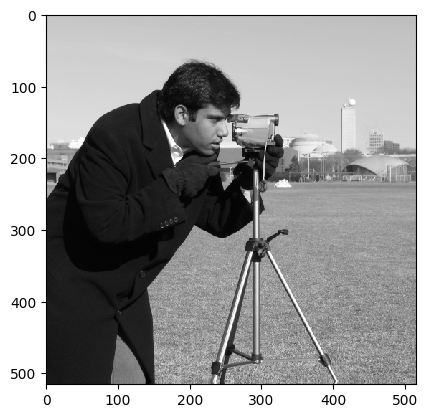

In [58]:

plt.imshow(stego_img, interpolation="nearest", cmap=plt.cm.gray)
# cv2.imwrite("comp.jpg", stego_img)
# img = cv2.imread("comp.jpg")
# stego_img, g, b = cv2.split(img)
# stego_img.shape

## Extracting

In [59]:
stego_img = blocking.pad_image(stego_img, 3)
# extract
iwt.forward(stego_img)
detail_coefficients = iwt.coefficients[-1]

detail_coefficients_blocks = [blocking.divide_image(coeff, block_size=3) for coeff in detail_coefficients]


In [60]:
encoded_data = []
for i, band in enumerate(detail_coefficients_blocks):
    for j, row in enumerate(band):
        for k, block in enumerate(row):
            encoded_data.extend(encoder.extract(block))


In [61]:
message = encoder.dec_to_message(encoded_data)

In [62]:
message[:50]

'1234 Secret message to be saved\x00\n"\x00"\x00("" (\x02\x00 *\x08\n *'